In [16]:
import json
import math
import os
import cv2
import tensorflow as tf
import shutil
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score,confusion_matrix, precision_score, recall_score, f1_score, classification_report
from mlxtend.plotting import plot_confusion_matrix
from tqdm import tqdm

In [17]:
np.random.seed(2019)
tf.random.set_seed(2019)

In [ ]:
os.makedirs('/kaggle/working/ddr-equal/train_images')

diagnosis
0    6266
2    4477
4     913
1     630
3     236
Name: count, dtype: int64

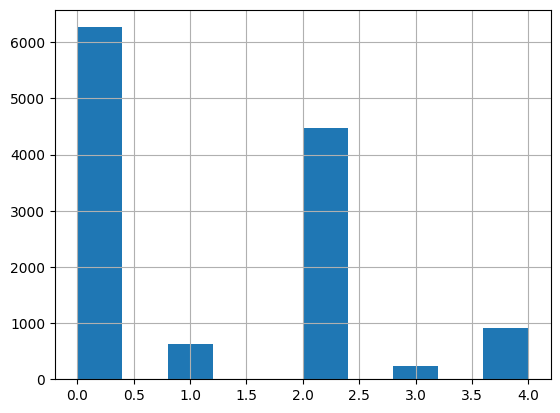

In [ ]:

file_path = f'D:\Final Year Project\Densenet\ddrdataset\DR_grading.csv'
data = pd.read_csv(file_path)
data['diagnosis'].hist()
data['diagnosis'].value_counts()

In [ ]:
# File already created
dict = {}
LABEL_SIZE = 236
count = [0, 0, 0, 0, 0]
rows = []

for i in data.index:
    dict[data['id_code'][i]] = data['diagnosis'][i]

for i in data.index:
    source_file_path = 'D:/Final Year Project/Densenet/ddrdataset/DR_grading/DR_grading/'+data['id_code'][i]
    destination_file_path = f'/kaggle/working/ddr-equal/train_images/'
    if count[data['diagnosis'][i]]<LABEL_SIZE and os.path.exists(source_file_path):
        rows.append([data['id_code'][i], data['diagnosis'][i]])
        shutil.copy(source_file_path, destination_file_path)
        count[data['diagnosis'][i]]+=1

columns = ['id_code', 'diagnosis']

df = pd.DataFrame(rows, columns=columns)
file_path = f'/kaggle/working/ddr-equal/train.csv'
df.to_csv(file_path, index=False)

In [19]:
datagen = ImageDataGenerator(
        zoom_range=0.15, 
        fill_mode='constant',
        cval=0.,  
        horizontal_flip=True,  
        vertical_flip=True,)

In [ ]:
df1 = pd.read_csv(f'/kaggle/working/ddr-equal/train.csv')
# df1.shape[0]

In [ ]:

os.makedirs('/kaggle/working/ddr-equal/aug_images',exist_ok=True)

In [ ]:


for j in range(df1.shape[0]):
    id_code = df1['id_code'][j]
    diagnosis = str(df1['diagnosis'][j])
    img = load_img(f'/kaggle/working/ddr-equal/train_images/{id_code}') 
    x = img_to_array(img)
    x = x.reshape((1, ) + x.shape) 
    
    i = 0
    for batch in datagen.flow(x, batch_size = 1, save_to_dir ='/kaggle/working/ddr-equal/aug_images', 
                            save_prefix = diagnosis + '_', save_format ='jpg'):
        i += 1
        if i > 5:
            break

In [ ]:


augmented_rows = []
aug_dir = '/kaggle/working/ddr-equal/aug_images'

for augmented_img_name in os.listdir(aug_dir):
    augmented_rows.append([augmented_img_name, int(augmented_img_name[0])])

columns = ['id_code', 'diagnosis']
df_augmented = pd.DataFrame(augmented_rows, columns=columns)
output_csv_path = '/kaggle/working/ddr-equal/aug.csv'
df_augmented.to_csv(output_csv_path, index=False)

In [20]:
train_df = pd.read_csv('/kaggle/working/ddr-equal/aug.csv')
print(train_df.shape)
train_df.head()

(6594, 2)


,id_code,diagnosis
0,0__0_8989.jpg,0
1,0__0_2738.jpg,0
2,0__0_7643.jpg,0
3,0__0_7122.jpg,0
4,0__0_1522.jpg,0


diagnosis
2    1329
3    1321
1    1318
4    1318
0    1308
Name: count, dtype: int64

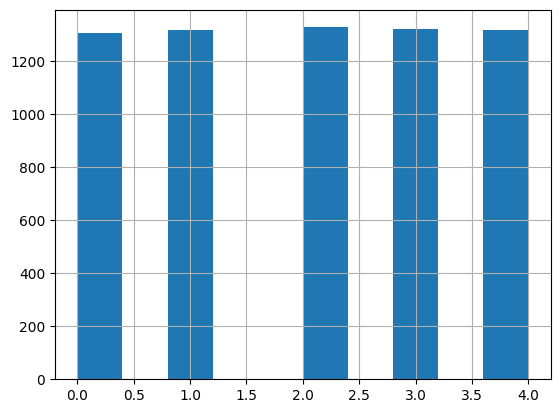

In [21]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

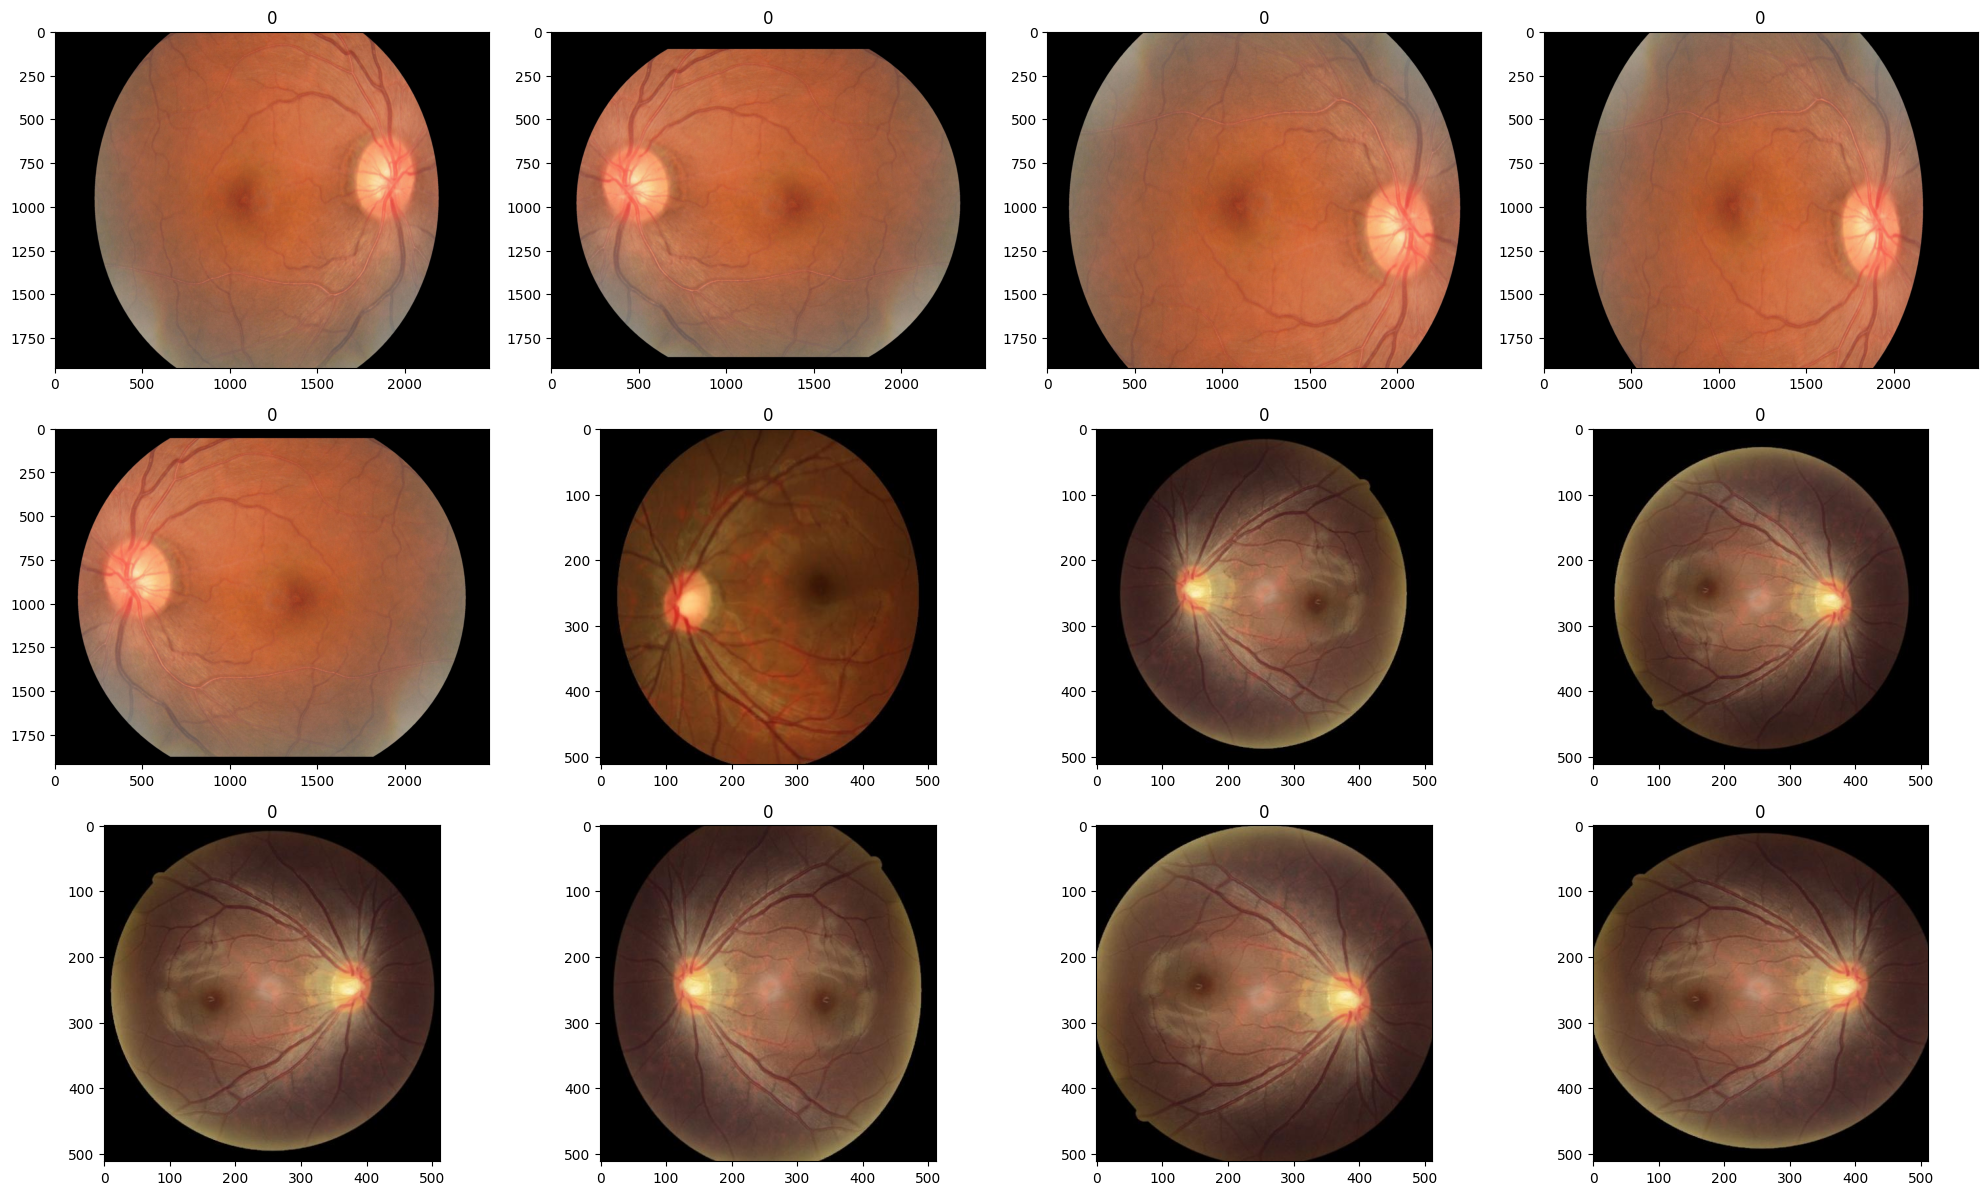

In [22]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'/kaggle/working/ddr-equal/aug_images/{image_path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

In [23]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [24]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(f'/kaggle/working/ddr-equal/aug_images/{image_id}')

100%|██████████| 6594/6594 [01:37<00:00, 67.32it/s] 


In [25]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print("One-hot encoded y_train:", y_train.sum(axis=0))

(6594, 224, 224, 3)
One-hot encoded y_train: [1308 1318 1329 1321 1318]


In [26]:
y_train.shape

(6594, 5)

In [ ]:
x_train_full, x_test, y_train_full, y_test = train_test_split(
    x_train,  
    y_train,
    test_size=0.1,
    random_state=2019
)

x_train_partial, x_val, y_train_partial, y_val = train_test_split(
    x_train_full, y_train_full, 
    test_size=0.1, 
    random_state=2019
)

x_train.shape

6594

In [ ]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15, 
        fill_mode='constant',
        cval=0.,  
        horizontal_flip=True,  
        vertical_flip=True,  
    )

data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)

In [ ]:
class Metrics(Callback):

    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.val_kappas = []

    def on_epoch_end(self, logs=None):
        logs = logs or {}
        X_val, y_val = self.validation_data
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic')

        self.val_kappas.append(_val_kappa)
        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('densenet_categorical_test.h5')
        return

In [ ]:
densenet = DenseNet121(
    weights='D:\Final Year Project\Densenet/archive\DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

In [ ]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))

    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [59]:
model = build_model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,042,629 (26.87 MB)

 Trainable params: 6,958,981 (26.55 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [ ]:
kappa_metrics = Metrics(validation_data=(x_val, y_val))

history = model.fit(data_generator, epochs=10, validation_data=(x_val, y_val), callbacks=[kappa_metrics],
                    steps_per_epoch=x_train.shape[0] // BATCH_SIZE)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step  - accurac


val_kappa: 0.0000
Validation Kappa has improved. Saving model.
206/206 ━━━━━━━━━━━━━━━━━━━━ 1193s 6s/step - accuracy: 0.4030 - loss: 1.7243 - val_accuracy: 0.6818 - val_loss: 0.8568
Epoch 2/10
  1/206 ━━━━━━━━━━━━━━━━━━━━ 17:37 5s/step - accuracy: 0.5312 - loss: 1.2680

z:\ml\ml\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step


val_kappa: 0.0000
Validation Kappa has improved. Saving model.
206/206 ━━━━━━━━━━━━━━━━━━━━ 50s 220ms/step - accuracy: 0.5312 - loss: 1.2680 - val_accuracy: 0.6818 - val_loss: 0.8541
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/stepp - accura


val_kappa: 0.0000
Validation Kappa has improved. Saving model.
206/206 ━━━━━━━━━━━━━━━━━━━━ 1108s 5s/step - accuracy: 0.7131 - loss: 0.7423 - val_accuracy: 0.8523 - val_loss: 0.3682
Epoch 4/10
  1/206 ━━━━━━━━━━━━━━━━━━━━ 17:49 5s/step - accuracy: 0.8125 - loss: 0.6436

z:\ml\ml\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step


val_kappa: 0.0000
Validation Kappa has improved. Saving model.
206/206 ━━━━━━━━━━━━━━━━━━━━ 48s 210ms/step - accuracy: 0.8125 - loss: 0.6436 - val_accuracy: 0.8561 - val_loss: 0.3664
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/stepp - accura


val_kappa: 0.0000
Validation Kappa has improved. Saving model.
206/206 ━━━━━━━━━━━━━━━━━━━━ 1110s 5s/step - accuracy: 0.8029 - loss: 0.5078 - val_accuracy: 0.8731 - val_loss: 0.3781
Epoch 6/10
  1/206 ━━━━━━━━━━━━━━━━━━━━ 17:37 5s/step - accuracy: 0.7188 - loss: 0.6562

z:\ml\ml\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step


val_kappa: 0.0000
Validation Kappa has improved. Saving model.
206/206 ━━━━━━━━━━━━━━━━━━━━ 48s 209ms/step - accuracy: 0.7188 - loss: 0.6562 - val_accuracy: 0.8712 - val_loss: 0.3753
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/stepp - accura


val_kappa: 0.0000
Validation Kappa has improved. Saving model.
206/206 ━━━━━━━━━━━━━━━━━━━━ 1102s 5s/step - accuracy: 0.8892 - loss: 0.2967 - val_accuracy: 0.9337 - val_loss: 0.2039
Epoch 8/10
  1/206 ━━━━━━━━━━━━━━━━━━━━ 17:29 5s/step - accuracy: 0.9062 - loss: 0.1993

z:\ml\ml\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step


val_kappa: 0.0000
Validation Kappa has improved. Saving model.
206/206 ━━━━━━━━━━━━━━━━━━━━ 47s 207ms/step - accuracy: 0.9062 - loss: 0.1993 - val_accuracy: 0.9356 - val_loss: 0.1934
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/stepp - accura


val_kappa: 0.0000
Validation Kappa has improved. Saving model.
206/206 ━━━━━━━━━━━━━━━━━━━━ 1107s 5s/step - accuracy: 0.9235 - loss: 0.2186 - val_accuracy: 0.9583 - val_loss: 0.1258
Epoch 10/10
  1/206 ━━━━━━━━━━━━━━━━━━━━ 17:33 5s/step - accuracy: 0.9688 - loss: 0.1483

z:\ml\ml\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step


val_kappa: 0.0000
Validation Kappa has improved. Saving model.
206/206 ━━━━━━━━━━━━━━━━━━━━ 48s 207ms/step - accuracy: 0.9688 - loss: 0.1483 - val_accuracy: 0.9602 - val_loss: 0.1208


In [ ]:
model.save('D:\Final Year Project\densenet.keras')

In [ ]:
y_pred = np.argmax(model.predict(x_test), axis=1)

42/42 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step


In [ ]:
y_true = np.argmax(y_test, axis=1)  

In [78]:
print(y_pred.shape)
print(y_true.shape)

(1319,)
(1319,)


Training history saved to 'history.json'.
Loaded history: {'accuracy': [0.5124961733818054, 0.53125, 0.7340749502182007, 0.8125, 0.8285583853721619, 0.71875, 0.8940871953964233, 0.90625, 0.9297470450401306, 0.96875], 'loss': [1.325566053390503, 1.2679603099822998, 0.686436653137207, 0.6436451077461243, 0.4550459682941437, 0.656181812286377, 0.2869405448436737, 0.19928860664367676, 0.19862259924411774, 0.14834411442279816], 'val_accuracy': [0.6818181872367859, 0.6818181872367859, 0.8522727489471436, 0.8560606241226196, 0.873106062412262, 0.8712121248245239, 0.9337121248245239, 0.935606062412262, 0.9583333134651184, 0.9602272510528564], 'val_loss': [0.856789767742157, 0.8541197776794434, 0.36817339062690735, 0.36636629700660706, 0.37807974219322205, 0.3753282427787781, 0.20393207669258118, 0.1934043914079666, 0.12576887011528015, 0.12078192085027695]}


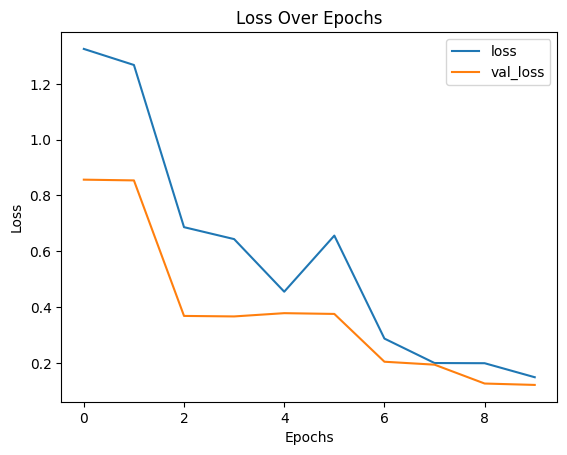

In [ ]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)
print("Training history saved to 'history.json'.")


with open('history.json', 'r') as f:
    loaded_history = json.load(f)
print("Loaded history:", loaded_history)


history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(title="Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

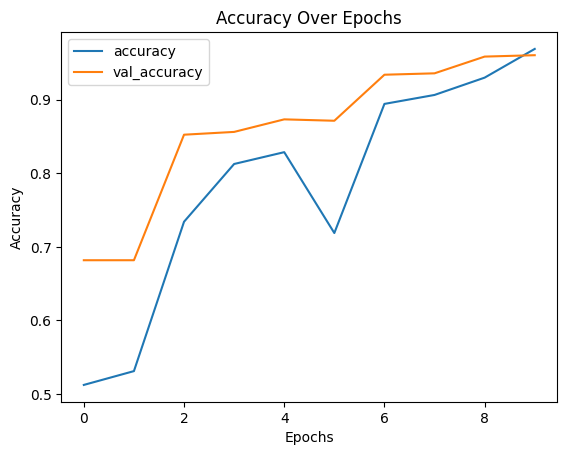

In [80]:
history_df[['accuracy', 'val_accuracy']].plot(title="Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred) 
print('Confusion matrix:')
print(conf_matrix)

Confusion matrix:
[[248   2   0   0   0]
 [ 27 245   8   0   0]
 [  5   9 250   2   0]
 [  0   0   1 243   0]
 [  0   2   3   5 269]]


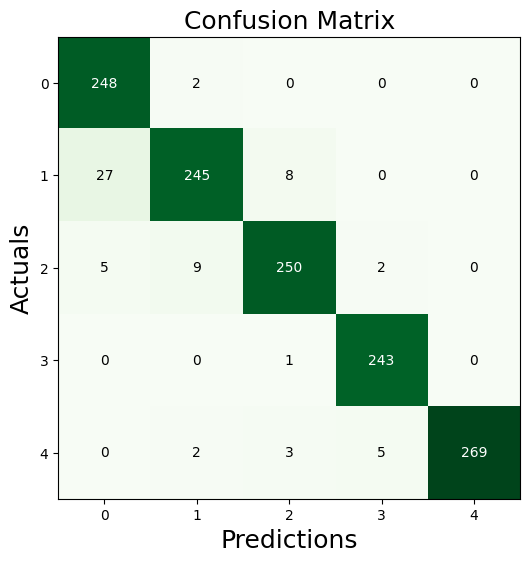

In [86]:
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [69]:
accuracy = accuracy_score(y_true, y_pred) 
print('\nAccuracy : ', accuracy)


Accuracy :  0.9893858984078847


In [70]:
macro_precision = precision_score(y_true, y_pred, average = 'macro') 
micro_precision = precision_score(y_true, y_pred, average = 'micro') 
weighted_precision = precision_score(y_true, y_pred, average = 'weighted') 

print('Macro Precision : ', macro_precision)
print('Micro Precision : ', micro_precision)
print('Weighted Precision : ', weighted_precision)

Macro Precision :  0.5
Micro Precision :  0.9893858984078847
Weighted Precision :  1.0


In [71]:
macro_recall = recall_score(y_true, y_pred, average = 'macro') 
micro_recall = recall_score(y_true, y_pred, average = 'micro') 
weighted_recall = recall_score(y_true, y_pred, average = 'weighted') 

print('Macro recall : ', macro_recall)
print('Micro recall : ', micro_recall)
print('Weighted recall : ', weighted_recall)

z:\ml\ml\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro recall :  0.49469294920394236
Micro recall :  0.9893858984078847
Weighted recall :  0.9893858984078847


z:\ml\ml\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [72]:
macro_f1 = f1_score(y_true, y_pred, average = 'macro') 
micro_f1 = f1_score(y_true, y_pred, average = 'micro') 
weighted_f1 = f1_score(y_true, y_pred, average = 'weighted') 

print('Macro f1 : ', macro_f1)
print('Micro f1 : ', micro_f1)
print('Weighted f1 : ', weighted_f1)

Macro f1 :  0.4973323170731707
Micro f1 :  0.9893858984078847
Weighted f1 :  0.9946646341463414


In [83]:
class_names = [str(i) for i in range(5)]
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       250
           1       0.95      0.88      0.91       280
           2       0.95      0.94      0.95       266
           3       0.97      1.00      0.98       244
           4       1.00      0.96      0.98       279

    accuracy                           0.95      1319
   macro avg       0.95      0.95      0.95      1319
weighted avg       0.95      0.95      0.95      1319

